# CNN Stock Price Prediction with Sentiment Analysis

This notebook implements a Convolutional Neural Network (CNN) for stock price prediction using historical data and sentiment analysis.

Based on: run.py

## 1. Import Libraries

In [1]:
import os
import json
import time
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime
from tqdm import tqdm
from core.data_processor import DataLoader
from core.CNN import Model

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Configuration and Setup

In [2]:
# Generate timestamp for results folder
current_time = datetime.now().strftime("%Y%m%d%H")

# Model and sentiment configuration
model_name = "CNN"
sentiment_type = "sentiment"  # Use "sentiment" or "nonsentiment"
config_file = sentiment_type + '_config.json'

# Load configuration
configs = json.load(open(config_file, 'r'))
print(f"Configuration loaded from {config_file}")
print(json.dumps(configs, indent=2))

Configuration loaded from sentiment_config.json
{
  "data": {
    "filename": "",
    "columns": [
      "Close",
      "Volume",
      "Scaled_sentiment"
    ],
    "columns_to_normalise": [
      0,
      1
    ],
    "sequence_length": 50,
    "prediction_length": 3,
    "train_test_split": 0.85,
    "normalise": true
  },
  "training": {
    "epochs": 20,
    "batch_size": 32
  },
  "model": {
    "loss": "mse",
    "optimizer": "adam",
    "save_dir": "saved_models",
    "layers": [
      {
        "type": "cnn",
        "neurons": 64,
        "kernel_size": 3,
        "input_timesteps": 49,
        "input_dim": 3
      },
      {
        "type": "cnn",
        "neurons": 32,
        "kernel_size": 3
      },
      {
        "type": "cnn",
        "neurons": 32,
        "kernel_size": 3
      },
      {
        "type": "cnn",
        "neurons": 32,
        "kernel_size": 3
      },
      {
        "type": "dropout",
        "rate": 0.2
      },
      {
        "type": "dense",
   

## 3. Define Stock Lists

In [3]:
# Stock lists for different test sizes

# Test csvs = 50
names_50 = ['aal.csv', 'AAPL.csv', 'ABBV.csv', 'AMD.csv', 'amgn.csv', 'AMZN.csv', 'BABA.csv',
            'bhp.csv', 'bidu.csv', 'biib.csv', 'BRK-B.csv', 'C.csv', 'cat.csv', 'cmcsa.csv', 'cmg.csv',
            'cop.csv', 'COST.csv', 'crm.csv', 'CVX.csv', 'dal.csv', 'DIS.csv', 'ebay.csv', 'GE.csv',
            'gild.csv', 'gld.csv', 'GOOG.csv', 'gsk.csv', 'INTC.csv', 'KO.csv', 'mrk.csv', 'MSFT.csv',
            'mu.csv', 'nke.csv', 'nvda.csv', 'orcl.csv', 'pep.csv', 'pypl.csv', 'qcom.csv', 'QQQ.csv',
            'SBUX.csv', 'T.csv', 'tgt.csv', 'tm.csv', 'TSLA.csv', 'TSM.csv', 'uso.csv', 'v.csv', 'WFC.csv',
            'WMT.csv', 'xlf.csv']

# Test csvs = 25
names_25 = ['AAPL.csv', 'ABBV.csv', 'AMZN.csv', 'BABA.csv', 'BRK-B.csv', 'C.csv', 'COST.csv', 'CVX.csv', 'DIS.csv',
            'GE.csv', 'INTC.csv', 'MSFT.csv', 'nvda.csv', 'pypl.csv', 'QQQ.csv', 'SBUX.csv', 'T.csv', 'TSLA.csv', 'WFC.csv',
            'KO.csv', 'AMD.csv', 'TSM.csv', 'GOOG.csv', 'WMT.csv']

# Test csvs = 5
names_5 = ['KO.csv', 'AMD.csv', 'TSM.csv', 'GOOG.csv', 'WMT.csv']

# Stocks to make predictions for
pred_names = ['KO', 'AMD', "TSM", "GOOG", 'WMT']

print(f"Stock lists defined:")
print(f"  names_5: {len(names_5)} stocks")
print(f"  names_25: {len(names_25)} stocks")
print(f"  names_50: {len(names_50)} stocks")

Stock lists defined:
  names_5: 5 stocks
  names_25: 24 stocks
  names_50: 50 stocks


## 4. Define Helper Functions

In [4]:
def output_results_and_errors_multiple(predicted_data, true_data, true_data_base, prediction_len, file_name,
                                       sentiment_type, num_csvs):
    """
    Save predictions, true values, and evaluation metrics to CSV files.
    """
    # Create DataFrame with results
    save_df = pd.DataFrame()
    save_df['True_Data'] = true_data.reshape(-1)
    save_df['Base'] = true_data_base.reshape(-1)
    save_df['True_Data_origin'] = (save_df['True_Data'] + 1) * save_df['Base']

    # Concatenate all predicted data
    if predicted_data:
        all_predicted_data = np.concatenate([p for p in predicted_data])
    else:
        all_predicted_data = predicted_data

    file_name = file_name.split(".")[0]
    sentiment_type = str(sentiment_type)

    save_df['Predicted_Data'] = pd.Series(all_predicted_data)
    save_df['Predicted_Data_origin'] = (save_df['Predicted_Data'] + 1) * save_df['Base']
    save_df = save_df.fillna(np.nan)

    # Create result folder and save predictions
    result_folder = f"test_result_{num_csvs}"
    save_file_path = os.path.join(result_folder, f"{file_name}_{sentiment_type}_{current_time}",
                                  f"{file_name}_{sentiment_type}_{current_time}_predicted_data.csv")
    os.makedirs(os.path.join(result_folder, f"{file_name}_{sentiment_type}_{current_time}"), exist_ok=True)
    save_df.to_csv(save_file_path, index=False)
    print(f"Data saved to {save_file_path}")

    # Calculate evaluation metrics
    min_length = min(len(save_df['Predicted_Data']), len(save_df['True_Data']))
    predicted_data = save_df['Predicted_Data'][:min_length]
    true_data = save_df['True_Data'][:min_length]

    mae = mean_absolute_error(true_data, predicted_data)
    mse = mean_squared_error(true_data, predicted_data)
    r2 = r2_score(true_data, predicted_data)

    results_df = pd.DataFrame({
        'MAE': [mae],
        'MSE': [mse],
        'R2': [r2]
    })

    eval_file_path = os.path.join(result_folder, f"{file_name}_{sentiment_type}_{current_time}",
                                  f"{file_name}_{sentiment_type}_{current_time}_eval.csv")
    results_df.to_csv(eval_file_path, index=False)
    print(f"Results saved to {eval_file_path}")
    print(f"Evaluation Metrics - MAE: {mae:.4f}, MSE: {mse:.4f}, R²: {r2:.4f}\n")

print("Helper functions defined!")

Helper functions defined!


## 5. Main Training and Prediction Function

In [5]:
def train_and_predict(configs, data_filename, sentiment_type, flag_pred, model_name, num_csvs, pred_names):
    """
    Train the CNN model and optionally make predictions.
    """
    symbol_name = data_filename.split('.')[0]
    print(f"\n{'='*60}")
    print(f"Processing: {symbol_name}")
    print(f"{'='*60}")

    # Create save directory
    if not os.path.exists(configs['model']['save_dir']):
        os.makedirs(configs['model']['save_dir'])

    # Load data
    data = DataLoader(
        os.path.join('data', data_filename),
        configs['data']['train_test_split'],
        configs['data']['columns'],
        configs['data']['columns_to_normalise'],
        configs['data']['prediction_length']
    )

    # Build or load model
    model = Model()
    model_path = f"saved_models/{model_name}_{sentiment_type}_{num_csvs}.h5"
    if os.path.exists(model_path):
        print(f"[Model] Loading model from {model_path}")
        model.load_model(model_path)
    else:
        print(f"[Model] Building new model")
        model.build_model(configs)

    # Get training data
    x, y = data.get_train_data(
        seq_len=configs['data']['sequence_length'],
        normalise=configs['data']['normalise']
    )
    print(f"Training data shapes - X: {x.shape}, Y: {y.shape}")

    # Train model
    steps_per_epoch = math.ceil(
        (data.len_train - configs['data']['sequence_length']) / configs['training']['batch_size'])
    
    print(f"[Model] Starting training...")
    model.train_generator(
        data_gen=data.generate_train_batch(
            seq_len=configs['data']['sequence_length'],
            batch_size=configs['training']['batch_size'],
            normalise=configs['data']['normalise']
        ),
        epochs=configs['training']['epochs'],
        batch_size=configs['training']['batch_size'],
        steps_per_epoch=steps_per_epoch,
        save_dir=configs['model']['save_dir'],
        sentiment_type=sentiment_type,
        model_name=model_name,
        num_csvs=num_csvs
    )

    # Make predictions if requested
    if flag_pred and symbol_name in pred_names:
        print(f"\n[Model] Starting predictions for {symbol_name}...")
        x_test, y_test, y_base = data.get_test_data(
            seq_len=configs['data']['sequence_length'],
            normalise=configs['data']['normalise'],
            cols_to_norm=configs['data']['columns_to_normalise']
        )
        print(f"Test data shapes - X: {x_test.shape}, Y: {y_test.shape}")

        predictions = model.predict_sequences_multiple_modified(
            x_test,
            configs['data']['sequence_length'],
            configs['data']['prediction_length']
        )

        output_results_and_errors_multiple(
            predictions, y_test, y_base,
            configs['data']['prediction_length'],
            symbol_name, sentiment_type, num_csvs
        )

print("Training function defined!")

Training function defined!


## 6. Execute Training and Prediction

Select your preferred configuration below:

### Option A: Train and predict on 5 stocks (Quick test)

In [6]:
# Train on 5 stocks with 3 runs, make predictions on the last run
names = names_5
num_stocks = len(names)

for i in tqdm(range(3)):
    if_pred = (i == 2)  # Make predictions on the third run
    print(f"\n\n{'#'*60}")
    print(f"RUN {i+1}/3 - Prediction: {if_pred}")
    print(f"{'#'*60}")
    
    for name in tqdm(names, desc=f"Processing {num_stocks} stocks (Run {i+1}/3)"):
        train_and_predict(configs, name, sentiment_type, if_pred, model_name, num_stocks, pred_names)



############################################################
RUN 1/3 - Prediction: False
############################################################


Processing 5 stocks (Run 1/3):   0%|          | 0/5 [00:00<?, ?it/s]


Processing: KO
[Model] Loading model from saved_models/CNN_sentiment_5.h5
[Model] Loading model from file saved_models/CNN_sentiment_5.h5
Training data shapes - X: (2982, 49, 3), Y: (2982, 1)
[Model] Starting training...
[Model] Training Started
[Model] 20 epochs, 32 batch size, 94 batches per epoch
Epoch 1/20
 1/94 [..............................] - ETA: 15s - loss: 6.7349e-04

/Users/nedpham/MachineLearning/ucl_stock_prediction/CNN/core/CNN.py:99: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  self.model.fit_generator(


94/94 [==============================] - 0s 2ms/step - loss: 8.8383e-04
Epoch 2/20
61/94 [==================>...........] - ETA: 0s - loss: 6.5094e-04

/opt/homebrew/Caskroom/miniconda/base/envs/ucl_stock_env/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


94/94 [==============================] - 0s 3ms/step - loss: 8.1918e-04
Epoch 3/20
94/94 [==============================] - 0s 3ms/step - loss: 8.0532e-04
Epoch 4/20
94/94 [==============================] - 0s 3ms/step - loss: 7.6503e-04
Epoch 5/20
94/94 [==============================] - 0s 3ms/step - loss: 7.6120e-04
Epoch 6/20
94/94 [==============================] - 0s 3ms/step - loss: 7.5272e-04
Epoch 7/20
94/94 [==============================] - 0s 3ms/step - loss: 7.4682e-04
Epoch 8/20
94/94 [==============================] - 0s 3ms/step - loss: 6.9507e-04
Epoch 9/20
94/94 [==============================] - 0s 3ms/step - loss: 7.2222e-04
Epoch 10/20
94/94 [==============================] - 0s 3ms/step - loss: 7.2587e-04
Epoch 11/20
94/94 [==============================] - 0s 3ms/step - loss: 6.9842e-04
Epoch 12/20
94/94 [==============================] - 0s 3ms/step - loss: 6.8031e-04
Epoch 13/20
94/94 [==============================] - 0s 3ms/step - loss: 6.9501e-04
Epoch 14/20

Processing 5 stocks (Run 1/3):  20%|██        | 1/5 [00:04<00:17,  4.48s/it]

[Model] Training Completed. Model saved as saved_models/CNN_sentiment_5.h5
Time taken: 0:00:04.267148

Processing: AMD
[Model] Loading model from saved_models/CNN_sentiment_5.h5
[Model] Loading model from file saved_models/CNN_sentiment_5.h5
Training data shapes - X: (1457, 49, 3), Y: (1457, 1)
[Model] Starting training...
[Model] Training Started
[Model] 20 epochs, 32 batch size, 46 batches per epoch
Epoch 1/20


/Users/nedpham/MachineLearning/ucl_stock_prediction/CNN/core/CNN.py:99: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  self.model.fit_generator(


46/46 [==============================] - 0s 3ms/step - loss: 0.0109
Epoch 2/20
46/46 [==============================] - 0s 3ms/step - loss: 0.0093
Epoch 3/20
20/46 [============>.................] - ETA: 0s - loss: 0.0091

/opt/homebrew/Caskroom/miniconda/base/envs/ucl_stock_env/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - 0s 3ms/step - loss: 0.0083
Epoch 4/20
46/46 [==============================] - 0s 3ms/step - loss: 0.0073
Epoch 5/20
46/46 [==============================] - 0s 3ms/step - loss: 0.0077
Epoch 6/20
46/46 [==============================] - 0s 3ms/step - loss: 0.0073
Epoch 7/20
46/46 [==============================] - 0s 3ms/step - loss: 0.0071
Epoch 8/20
46/46 [==============================] - 0s 3ms/step - loss: 0.0066
Epoch 9/20
46/46 [==============================] - 0s 3ms/step - loss: 0.0065
Epoch 10/20
46/46 [==============================] - 0s 3ms/step - loss: 0.0066
Epoch 11/20
46/46 [==============================] - 0s 3ms/step - loss: 0.0066
Epoch 12/20
46/46 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 13/20
46/46 [==============================] - 0s 3ms/step - loss: 0.0062
Epoch 14/20
46/46 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 15/20
46/46 [==============================] - 0s 3m

Processing 5 stocks (Run 1/3):  40%|████      | 2/5 [00:07<00:10,  3.57s/it]

[Model] Training Completed. Model saved as saved_models/CNN_sentiment_5.h5
Time taken: 0:00:02.850244

Processing: TSM
[Model] Loading model from saved_models/CNN_sentiment_5.h5
[Model] Loading model from file saved_models/CNN_sentiment_5.h5
Training data shapes - X: (2876, 49, 3), Y: (2876, 1)
[Model] Starting training...
[Model] Training Started
[Model] 20 epochs, 32 batch size, 90 batches per epoch
Epoch 1/20


/Users/nedpham/MachineLearning/ucl_stock_prediction/CNN/core/CNN.py:99: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  self.model.fit_generator(


90/90 [==============================] - 0s 3ms/step - loss: 0.0027
Epoch 2/20
56/90 [=================>............] - ETA: 0s - loss: 0.0019

/opt/homebrew/Caskroom/miniconda/base/envs/ucl_stock_env/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


90/90 [==============================] - 0s 3ms/step - loss: 0.0024
Epoch 3/20
90/90 [==============================] - 0s 3ms/step - loss: 0.0022
Epoch 4/20
90/90 [==============================] - 0s 3ms/step - loss: 0.0021
Epoch 5/20
90/90 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 6/20
90/90 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 7/20
90/90 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 8/20
90/90 [==============================] - 0s 3ms/step - loss: 0.0019
Epoch 9/20
90/90 [==============================] - 0s 375us/step - loss: 0.0025


Processing 5 stocks (Run 1/3):  60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

[Model] Training Completed. Model saved as saved_models/CNN_sentiment_5.h5
Time taken: 0:00:02.409261

Processing: GOOG
[Model] Loading model from saved_models/CNN_sentiment_5.h5
[Model] Loading model from file saved_models/CNN_sentiment_5.h5
Training data shapes - X: (991, 49, 3), Y: (991, 1)
[Model] Starting training...
[Model] Training Started
[Model] 20 epochs, 32 batch size, 31 batches per epoch
Epoch 1/20


/Users/nedpham/MachineLearning/ucl_stock_prediction/CNN/core/CNN.py:99: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  self.model.fit_generator(


31/31 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 2/20
31/31 [==============================] - 0s 3ms/step - loss: 0.0478
Epoch 3/20
31/31 [==============================] - 0s 3ms/step - loss: 0.0183
Epoch 4/20
 1/31 [..............................] - ETA: 0s - loss: 0.0024

/opt/homebrew/Caskroom/miniconda/base/envs/ucl_stock_env/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 0s 3ms/step - loss: 0.0268
Epoch 5/20
31/31 [==============================] - 0s 3ms/step - loss: 0.0101
Epoch 6/20
31/31 [==============================] - 0s 3ms/step - loss: 0.0099
Epoch 7/20
31/31 [==============================] - 0s 3ms/step - loss: 0.0179
Epoch 8/20
31/31 [==============================] - 0s 3ms/step - loss: 0.0170
Epoch 9/20
31/31 [==============================] - 0s 3ms/step - loss: 0.0268
Epoch 10/20
31/31 [==============================] - 0s 3ms/step - loss: 0.0109
Epoch 11/20
31/31 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 12/20
31/31 [==============================] - 0s 3ms/step - loss: 0.0159
Epoch 13/20
31/31 [==============================] - 0s 3ms/step - loss: 0.0107
Epoch 14/20
31/31 [==============================] - 0s 3ms/step - loss: 0.0097
Epoch 15/20
31/31 [==============================] - 0s 3ms/step - loss: 0.0107
Epoch 16/20
31/31 [==============================] - 0s 3

Processing 5 stocks (Run 1/3):  80%|████████  | 4/5 [00:12<00:02,  2.72s/it]

[Model] Training Completed. Model saved as saved_models/CNN_sentiment_5.h5
Time taken: 0:00:02.098650

Processing: WMT
[Model] Loading model from saved_models/CNN_sentiment_5.h5
[Model] Loading model from file saved_models/CNN_sentiment_5.h5
Training data shapes - X: (1027, 49, 3), Y: (1027, 1)
[Model] Starting training...
[Model] Training Started
[Model] 20 epochs, 32 batch size, 33 batches per epoch
Epoch 1/20


/Users/nedpham/MachineLearning/ucl_stock_prediction/CNN/core/CNN.py:99: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  self.model.fit_generator(


33/33 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 2/20
33/33 [==============================] - 0s 3ms/step - loss: 0.0015
Epoch 3/20
20/33 [=================>............] - ETA: 0s - loss: 0.0012    

/opt/homebrew/Caskroom/miniconda/base/envs/ucl_stock_env/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 4/20
33/33 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 5/20
33/33 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 6/20
33/33 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 7/20
33/33 [==============================] - 0s 3ms/step - loss: 0.0012
Epoch 8/20
33/33 [==============================] - 0s 3ms/step - loss: 0.0012
Epoch 9/20
33/33 [==============================] - 0s 3ms/step - loss: 0.0012
Epoch 10/20
33/33 [==============================] - 0s 3ms/step - loss: 0.0012
Epoch 11/20
33/33 [==============================] - 0s 3ms/step - loss: 0.0012
Epoch 12/20
33/33 [==============================] - 0s 3ms/step - loss: 0.0011
Epoch 13/20
33/33 [==============================] - 0s 3ms/step - loss: 0.0011
Epoch 14/20
33/33 [==============================] - 0s 3ms/step - loss: 0.0011
Epoch 15/20
33/33 [==============================] - 0s 3m

Processing 5 stocks (Run 1/3): 100%|██████████| 5/5 [00:14<00:00,  2.89s/it]


[Model] Training Completed. Model saved as saved_models/CNN_sentiment_5.h5
Time taken: 0:00:02.264741


############################################################
RUN 2/3 - Prediction: False
############################################################


Processing 5 stocks (Run 2/3):   0%|          | 0/5 [00:00<?, ?it/s]


Processing: KO
[Model] Loading model from saved_models/CNN_sentiment_5.h5
[Model] Loading model from file saved_models/CNN_sentiment_5.h5
Training data shapes - X: (2982, 49, 3), Y: (2982, 1)
[Model] Starting training...
[Model] Training Started
[Model] 20 epochs, 32 batch size, 94 batches per epoch
Epoch 1/20


/Users/nedpham/MachineLearning/ucl_stock_prediction/CNN/core/CNN.py:99: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  self.model.fit_generator(


94/94 [==============================] - 0s 3ms/step - loss: 9.2099e-04
Epoch 2/20
53/94 [===============>..............] - ETA: 0s - loss: 7.7251e-04

/opt/homebrew/Caskroom/miniconda/base/envs/ucl_stock_env/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


94/94 [==============================] - 0s 3ms/step - loss: 8.7449e-04
Epoch 3/20
94/94 [==============================] - 0s 3ms/step - loss: 8.2633e-04
Epoch 4/20
94/94 [==============================] - 0s 3ms/step - loss: 7.6201e-04
Epoch 5/20
94/94 [==============================] - 0s 3ms/step - loss: 7.4138e-04
Epoch 6/20
94/94 [==============================] - 0s 3ms/step - loss: 7.2905e-04
Epoch 7/20
94/94 [==============================] - 0s 3ms/step - loss: 7.1715e-04
Epoch 8/20
94/94 [==============================] - 0s 3ms/step - loss: 7.0785e-04
Epoch 9/20
94/94 [==============================] - 0s 3ms/step - loss: 6.9412e-04
Epoch 10/20
94/94 [==============================] - 0s 3ms/step - loss: 6.8610e-04
Epoch 11/20
94/94 [==============================] - 0s 3ms/step - loss: 6.7422e-04
Epoch 12/20
94/94 [==============================] - 0s 3ms/step - loss: 6.6865e-04
Epoch 13/20
94/94 [==============================] - 0s 3ms/step - loss: 6.6778e-04
Epoch 14/20

Processing 5 stocks (Run 2/3):  20%|██        | 1/5 [00:04<00:19,  4.92s/it]

[Model] Training Completed. Model saved as saved_models/CNN_sentiment_5.h5
Time taken: 0:00:04.806257

Processing: AMD
[Model] Loading model from saved_models/CNN_sentiment_5.h5
[Model] Loading model from file saved_models/CNN_sentiment_5.h5
Training data shapes - X: (1457, 49, 3), Y: (1457, 1)
[Model] Starting training...
[Model] Training Started
[Model] 20 epochs, 32 batch size, 46 batches per epoch
Epoch 1/20


/Users/nedpham/MachineLearning/ucl_stock_prediction/CNN/core/CNN.py:99: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  self.model.fit_generator(


46/46 [==============================] - 0s 4ms/step - loss: 0.0105
Epoch 2/20
46/46 [==============================] - 0s 4ms/step - loss: 0.0078
Epoch 3/20
 1/46 [..............................] - ETA: 0s - loss: 0.0014

/opt/homebrew/Caskroom/miniconda/base/envs/ucl_stock_env/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - 0s 4ms/step - loss: 0.0074
Epoch 4/20
46/46 [==============================] - 0s 3ms/step - loss: 0.0066
Epoch 5/20
46/46 [==============================] - 0s 3ms/step - loss: 0.0065
Epoch 6/20
46/46 [==============================] - 0s 3ms/step - loss: 0.0059
Epoch 7/20
46/46 [==============================] - 0s 3ms/step - loss: 0.0065
Epoch 8/20
46/46 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 9/20
46/46 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 10/20
46/46 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 11/20
46/46 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 12/20
46/46 [==============================] - 0s 4ms/step - loss: 0.0060
Epoch 13/20
46/46 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 14/20
46/46 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 15/20
46/46 [==============================] - 0s 3m

Processing 5 stocks (Run 2/3):  40%|████      | 2/5 [00:08<00:12,  4.04s/it]

[Model] Training Completed. Model saved as saved_models/CNN_sentiment_5.h5
Time taken: 0:00:03.269417

Processing: TSM
[Model] Loading model from saved_models/CNN_sentiment_5.h5
[Model] Loading model from file saved_models/CNN_sentiment_5.h5
Training data shapes - X: (2876, 49, 3), Y: (2876, 1)
[Model] Starting training...
[Model] Training Started
[Model] 20 epochs, 32 batch size, 90 batches per epoch
Epoch 1/20


/Users/nedpham/MachineLearning/ucl_stock_prediction/CNN/core/CNN.py:99: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  self.model.fit_generator(


90/90 [==============================] - 0s 3ms/step - loss: 0.0031
Epoch 2/20
49/90 [===============>..............] - ETA: 0s - loss: 0.0021

/opt/homebrew/Caskroom/miniconda/base/envs/ucl_stock_env/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


90/90 [==============================] - 0s 4ms/step - loss: 0.0025
Epoch 3/20
90/90 [==============================] - 0s 3ms/step - loss: 0.0022
Epoch 4/20
90/90 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 5/20
90/90 [==============================] - 0s 3ms/step - loss: 0.0021
Epoch 6/20
90/90 [==============================] - 0s 3ms/step - loss: 0.0021
Epoch 7/20
90/90 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 8/20
90/90 [==============================] - 0s 3ms/step - loss: 0.0019
Epoch 9/20
90/90 [==============================] - 0s 395us/step - loss: 0.0029


Processing 5 stocks (Run 2/3):  60%|██████    | 3/5 [00:11<00:06,  3.44s/it]

[Model] Training Completed. Model saved as saved_models/CNN_sentiment_5.h5
Time taken: 0:00:02.611247

Processing: GOOG
[Model] Loading model from saved_models/CNN_sentiment_5.h5
[Model] Loading model from file saved_models/CNN_sentiment_5.h5
Training data shapes - X: (991, 49, 3), Y: (991, 1)
[Model] Starting training...
[Model] Training Started
[Model] 20 epochs, 32 batch size, 31 batches per epoch
Epoch 1/20


/Users/nedpham/MachineLearning/ucl_stock_prediction/CNN/core/CNN.py:99: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  self.model.fit_generator(


31/31 [==============================] - 0s 3ms/step - loss: 0.0108
Epoch 2/20
31/31 [==============================] - 0s 3ms/step - loss: 0.0265
Epoch 3/20
31/31 [==============================] - 0s 3ms/step - loss: 0.0693
Epoch 4/20
 1/31 [..............................] - ETA: 0s - loss: 0.0071

/opt/homebrew/Caskroom/miniconda/base/envs/ucl_stock_env/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 0s 5ms/step - loss: 0.0300
Epoch 5/20
31/31 [==============================] - 0s 3ms/step - loss: 0.0496
Epoch 6/20
31/31 [==============================] - 0s 3ms/step - loss: 0.0432
Epoch 7/20
31/31 [==============================] - 0s 10ms/step - loss: 0.0181
Epoch 8/20
31/31 [==============================] - 0s 3ms/step - loss: 0.0304
Epoch 9/20
31/31 [==============================] - 0s 3ms/step - loss: 0.0421
Epoch 10/20
31/31 [==============================] - 0s 3ms/step - loss: 0.0281
Epoch 11/20
31/31 [==============================] - 0s 3ms/step - loss: 0.0170
Epoch 12/20
31/31 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 13/20
31/31 [==============================] - 0s 4ms/step - loss: 0.0097
Epoch 14/20
31/31 [==============================] - 0s 4ms/step - loss: 0.0089
Epoch 15/20
31/31 [==============================] - 0s 4ms/step - loss: 0.0087
Epoch 16/20
31/31 [==============================] - 0s 

Processing 5 stocks (Run 2/3):  80%|████████  | 4/5 [00:13<00:03,  3.16s/it]

[Model] Training Completed. Model saved as saved_models/CNN_sentiment_5.h5
Time taken: 0:00:02.651729

Processing: WMT
[Model] Loading model from saved_models/CNN_sentiment_5.h5
[Model] Loading model from file saved_models/CNN_sentiment_5.h5
Training data shapes - X: (1027, 49, 3), Y: (1027, 1)
[Model] Starting training...
[Model] Training Started
[Model] 20 epochs, 32 batch size, 33 batches per epoch
Epoch 1/20


/Users/nedpham/MachineLearning/ucl_stock_prediction/CNN/core/CNN.py:99: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  self.model.fit_generator(


33/33 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 2/20
33/33 [==============================] - 0s 3ms/step - loss: 0.0016
Epoch 3/20
18/33 [===============>..............] - ETA: 0s - loss: 0.0014

/opt/homebrew/Caskroom/miniconda/base/envs/ucl_stock_env/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 0s 3ms/step - loss: 0.0015
Epoch 4/20
33/33 [==============================] - 0s 3ms/step - loss: 0.0014
Epoch 5/20
33/33 [==============================] - 0s 3ms/step - loss: 0.0014
Epoch 6/20
33/33 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 7/20
33/33 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 8/20
33/33 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 9/20
33/33 [==============================] - 0s 3ms/step - loss: 0.0012
Epoch 10/20
33/33 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 11/20
33/33 [==============================] - 0s 3ms/step - loss: 0.0012
Epoch 12/20
33/33 [==============================] - 0s 3ms/step - loss: 0.0012
Epoch 13/20
33/33 [==============================] - 0s 3ms/step - loss: 0.0012
Epoch 14/20
33/33 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 15/20
33/33 [==============================] - 0s 3m

Processing 5 stocks (Run 2/3): 100%|██████████| 5/5 [00:16<00:00,  3.28s/it]


[Model] Training Completed. Model saved as saved_models/CNN_sentiment_5.h5
Time taken: 0:00:02.480653


############################################################
RUN 3/3 - Prediction: True
############################################################


Processing 5 stocks (Run 3/3):   0%|          | 0/5 [00:00<?, ?it/s]


Processing: KO
[Model] Loading model from saved_models/CNN_sentiment_5.h5
[Model] Loading model from file saved_models/CNN_sentiment_5.h5
Training data shapes - X: (2982, 49, 3), Y: (2982, 1)
[Model] Starting training...
[Model] Training Started
[Model] 20 epochs, 32 batch size, 94 batches per epoch
Epoch 1/20


/Users/nedpham/MachineLearning/ucl_stock_prediction/CNN/core/CNN.py:99: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  self.model.fit_generator(


94/94 [==============================] - 0s 4ms/step - loss: 9.1146e-04
Epoch 2/20
48/94 [==============>...............] - ETA: 0s - loss: 7.6486e-04

/opt/homebrew/Caskroom/miniconda/base/envs/ucl_stock_env/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


94/94 [==============================] - 0s 4ms/step - loss: 8.6126e-04
Epoch 3/20
94/94 [==============================] - 0s 4ms/step - loss: 8.3696e-04
Epoch 4/20
94/94 [==============================] - 0s 3ms/step - loss: 8.1273e-04
Epoch 5/20
94/94 [==============================] - 0s 3ms/step - loss: 7.8752e-04
Epoch 6/20
94/94 [==============================] - 0s 3ms/step - loss: 7.7664e-04
Epoch 7/20
94/94 [==============================] - 0s 3ms/step - loss: 7.6039e-04
Epoch 8/20
94/94 [==============================] - 0s 3ms/step - loss: 7.3132e-04
Epoch 9/20
94/94 [==============================] - 0s 3ms/step - loss: 7.0770e-04
Epoch 10/20
94/94 [==============================] - 0s 3ms/step - loss: 7.1823e-04
Epoch 11/20
94/94 [==============================] - 0s 3ms/step - loss: 7.0967e-04
Epoch 12/20
94/94 [==============================] - 0s 3ms/step - loss: 6.8827e-04
Epoch 13/20
94/94 [==============================] - 0s 3ms/step - loss: 6.6932e-04
Epoch 14/20

Processing 5 stocks (Run 3/3):  20%|██        | 1/5 [00:16<01:07, 16.92s/it]

Data saved to test_result_5/KO_sentiment_2026013102/KO_sentiment_2026013102_predicted_data.csv
Results saved to test_result_5/KO_sentiment_2026013102/KO_sentiment_2026013102_eval.csv
Evaluation Metrics - MAE: 0.0239, MSE: 0.0009, R²: 0.7945


Processing: AMD
[Model] Loading model from saved_models/CNN_sentiment_5.h5
[Model] Loading model from file saved_models/CNN_sentiment_5.h5
Training data shapes - X: (1457, 49, 3), Y: (1457, 1)
[Model] Starting training...
[Model] Training Started
[Model] 20 epochs, 32 batch size, 46 batches per epoch
Epoch 1/20


/Users/nedpham/MachineLearning/ucl_stock_prediction/CNN/core/CNN.py:99: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  self.model.fit_generator(


46/46 [==============================] - 0s 3ms/step - loss: 0.0100
Epoch 2/20
46/46 [==============================] - 0s 3ms/step - loss: 0.0086
Epoch 3/20
 1/46 [..............................] - ETA: 0s - loss: 0.0021

/opt/homebrew/Caskroom/miniconda/base/envs/ucl_stock_env/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - 0s 3ms/step - loss: 0.0081
Epoch 4/20
46/46 [==============================] - 0s 3ms/step - loss: 0.0066
Epoch 5/20
46/46 [==============================] - 0s 3ms/step - loss: 0.0070
Epoch 6/20
46/46 [==============================] - 0s 3ms/step - loss: 0.0062
Epoch 7/20
46/46 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 8/20
46/46 [==============================] - 0s 3ms/step - loss: 0.0065
Epoch 9/20
46/46 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 10/20
46/46 [==============================] - 0s 4ms/step - loss: 0.0064
Epoch 11/20
46/46 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 12/20
46/46 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 13/20
46/46 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 14/20
46/46 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 15/20
46/46 [==============================] - 0s 3m

Processing 5 stocks (Run 3/3):  40%|████      | 2/5 [00:25<00:36, 12.11s/it]

Data saved to test_result_5/AMD_sentiment_2026013102/AMD_sentiment_2026013102_predicted_data.csv
Results saved to test_result_5/AMD_sentiment_2026013102/AMD_sentiment_2026013102_eval.csv
Evaluation Metrics - MAE: 0.0749, MSE: 0.0094, R²: 0.6828


Processing: TSM
[Model] Loading model from saved_models/CNN_sentiment_5.h5
[Model] Loading model from file saved_models/CNN_sentiment_5.h5
Training data shapes - X: (2876, 49, 3), Y: (2876, 1)
[Model] Starting training...
[Model] Training Started
[Model] 20 epochs, 32 batch size, 90 batches per epoch
Epoch 1/20


/Users/nedpham/MachineLearning/ucl_stock_prediction/CNN/core/CNN.py:99: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  self.model.fit_generator(


90/90 [==============================] - 0s 3ms/step - loss: 0.0029
Epoch 2/20
49/90 [===============>..............] - ETA: 0s - loss: 0.0021

/opt/homebrew/Caskroom/miniconda/base/envs/ucl_stock_env/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


90/90 [==============================] - 0s 4ms/step - loss: 0.0025
Epoch 3/20
90/90 [==============================] - 0s 4ms/step - loss: 0.0022
Epoch 4/20
90/90 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 5/20
90/90 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 6/20
90/90 [==============================] - 0s 4ms/step - loss: 0.0020
Epoch 7/20
90/90 [==============================] - 0s 3ms/step - loss: 0.0019
Epoch 8/20
90/90 [==============================] - 0s 3ms/step - loss: 0.0017
Epoch 9/20
90/90 [==============================] - 0s 394us/step - loss: 0.0021
[Model] Training Completed. Model saved as saved_models/CNN_sentiment_5.h5
Time taken: 0:00:02.737007

[Model] Starting predictions for TSM...
Test data shapes - X: (467, 49, 3), Y: (467, 1)


Processing 5 stocks (Run 3/3):  60%|██████    | 3/5 [00:39<00:26, 13.04s/it]

Data saved to test_result_5/TSM_sentiment_2026013102/TSM_sentiment_2026013102_predicted_data.csv
Results saved to test_result_5/TSM_sentiment_2026013102/TSM_sentiment_2026013102_eval.csv
Evaluation Metrics - MAE: 0.0548, MSE: 0.0046, R²: 0.8005


Processing: GOOG
[Model] Loading model from saved_models/CNN_sentiment_5.h5
[Model] Loading model from file saved_models/CNN_sentiment_5.h5
Training data shapes - X: (991, 49, 3), Y: (991, 1)
[Model] Starting training...
[Model] Training Started
[Model] 20 epochs, 32 batch size, 31 batches per epoch
Epoch 1/20


/Users/nedpham/MachineLearning/ucl_stock_prediction/CNN/core/CNN.py:99: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  self.model.fit_generator(


31/31 [==============================] - 0s 6ms/step - loss: 0.0198
Epoch 2/20
31/31 [==============================] - 0s 4ms/step - loss: 0.0189
Epoch 3/20
16/31 [==============>...............] - ETA: 0s - loss: 0.1608

/opt/homebrew/Caskroom/miniconda/base/envs/ucl_stock_env/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 0s 3ms/step - loss: 0.0852
Epoch 4/20
31/31 [==============================] - 0s 4ms/step - loss: 0.0311
Epoch 5/20
31/31 [==============================] - 0s 3ms/step - loss: 0.0852
Epoch 6/20
31/31 [==============================] - 0s 3ms/step - loss: 0.0374
Epoch 7/20
31/31 [==============================] - 0s 3ms/step - loss: 0.0236
Epoch 8/20
31/31 [==============================] - 0s 4ms/step - loss: 0.0116
Epoch 9/20
31/31 [==============================] - 0s 4ms/step - loss: 0.0096
Epoch 10/20
31/31 [==============================] - 0s 3ms/step - loss: 0.0111
Epoch 11/20
31/31 [==============================] - 0s 3ms/step - loss: 0.0141
Epoch 12/20
31/31 [==============================] - 0s 3ms/step - loss: 0.0143
Epoch 13/20
31/31 [==============================] - 0s 4ms/step - loss: 0.0088
Epoch 14/20
31/31 [==============================] - 0s 3ms/step - loss: 0.0094
Epoch 15/20
31/31 [==============================] - 0s 3m

Processing 5 stocks (Run 3/3):  80%|████████  | 4/5 [00:45<00:10, 10.10s/it]

Data saved to test_result_5/GOOG_sentiment_2026013102/GOOG_sentiment_2026013102_predicted_data.csv
Results saved to test_result_5/GOOG_sentiment_2026013102/GOOG_sentiment_2026013102_eval.csv
Evaluation Metrics - MAE: 0.0343, MSE: 0.0020, R²: 0.5730


Processing: WMT
[Model] Loading model from saved_models/CNN_sentiment_5.h5
[Model] Loading model from file saved_models/CNN_sentiment_5.h5
Training data shapes - X: (1027, 49, 3), Y: (1027, 1)
[Model] Starting training...
[Model] Training Started
[Model] 20 epochs, 32 batch size, 33 batches per epoch
Epoch 1/20


/Users/nedpham/MachineLearning/ucl_stock_prediction/CNN/core/CNN.py:99: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  self.model.fit_generator(


33/33 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 2/20
33/33 [==============================] - 0s 3ms/step - loss: 0.0015
Epoch 3/20
17/33 [==============>...............] - ETA: 0s - loss: 0.0013    

/opt/homebrew/Caskroom/miniconda/base/envs/ucl_stock_env/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 0s 3ms/step - loss: 0.0015
Epoch 4/20
33/33 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 5/20
33/33 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 6/20
33/33 [==============================] - 0s 3ms/step - loss: 0.0014
Epoch 7/20
33/33 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 8/20
33/33 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 9/20
33/33 [==============================] - 0s 3ms/step - loss: 0.0012
Epoch 10/20
33/33 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 11/20
33/33 [==============================] - 0s 3ms/step - loss: 0.0012
Epoch 12/20
33/33 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 13/20
33/33 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 14/20
33/33 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 15/20
33/33 [==============================] - 0s 4m

Processing 5 stocks (Run 3/3): 100%|██████████| 5/5 [00:51<00:00, 10.27s/it]

Data saved to test_result_5/WMT_sentiment_2026013102/WMT_sentiment_2026013102_predicted_data.csv
Results saved to test_result_5/WMT_sentiment_2026013102/WMT_sentiment_2026013102_eval.csv
Evaluation Metrics - MAE: 0.0199, MSE: 0.0006, R²: 0.5759



### Option B: Train and predict on 25 stocks (Medium test)

In [ ]:
# Train on 25 stocks with 3 runs, make predictions on the last run
names = names_25
num_stocks = len(names)

for i in range(3):
    if_pred = (i == 2)  # Make predictions on the third run
    print(f"\n\n{'#'*60}")
    print(f"RUN {i+1}/3 - Prediction: {if_pred}")
    print(f"{'#'*60}")
    
    for name in tqdm(names, desc=f"Processing {num_stocks} stocks (Run {i+1}/3)"):
        train_and_predict(configs, name, sentiment_type, if_pred, model_name, num_stocks, pred_names)

### Option C: Train and predict on 50 stocks (Full test)

In [ ]:
# Train on 50 stocks with 3 runs, make predictions on the last run
names = names_50
num_stocks = len(names)

for i in range(3):
    if_pred = (i == 2)  # Make predictions on the third run
    print(f"\n\n{'#'*60}")
    print(f"RUN {i+1}/3 - Prediction: {if_pred}")
    print(f"{'#'*60}")
    
    for name in tqdm(names, desc=f"Processing {num_stocks} stocks (Run {i+1}/3)"):
        train_and_predict(configs, name, sentiment_type, if_pred, model_name, num_stocks, pred_names)

## 7. Results Summary

After running the training above, results will be saved in:
- `test_result_5/`, `test_result_25/`, or `test_result_50/` (depending on number of stocks)
- Each stock has a subfolder containing:
  - `*_predicted_data.csv`: Predictions and true values
  - `*_eval.csv`: Evaluation metrics (MAE, MSE, R²)

In [7]:
# Display available results
import glob

result_folders = glob.glob('test_result_*')
if result_folders:
    print("Available results:")
    for folder in sorted(result_folders):
        subfolders = glob.glob(os.path.join(folder, '*'))
        print(f"\n{folder}:")
        for subfolder in sorted(subfolders):
            print(f"  - {os.path.basename(subfolder)}")
else:
    print("No results found yet. Run training first!")

Available results:

test_result_24:
  - AMD_sentiment_2026013101
  - GOOG_sentiment_2026013101
  - KO_sentiment_2026013101
  - TSM_sentiment_2026013101
  - WMT_sentiment_2026013101

test_result_5:
  - AMD_sentiment_2026013101
  - AMD_sentiment_2026013102
  - GOOG_sentiment_2026013101
  - GOOG_sentiment_2026013102
  - KO_sentiment_2026013101
  - KO_sentiment_2026013102
  - TSM_sentiment_2026013101
  - TSM_sentiment_2026013102
  - WMT_sentiment_2026013101
  - WMT_sentiment_2026013102



Plotting results for 5 stocks


Plot saved as predictions_vs_actual_5_stocks.png


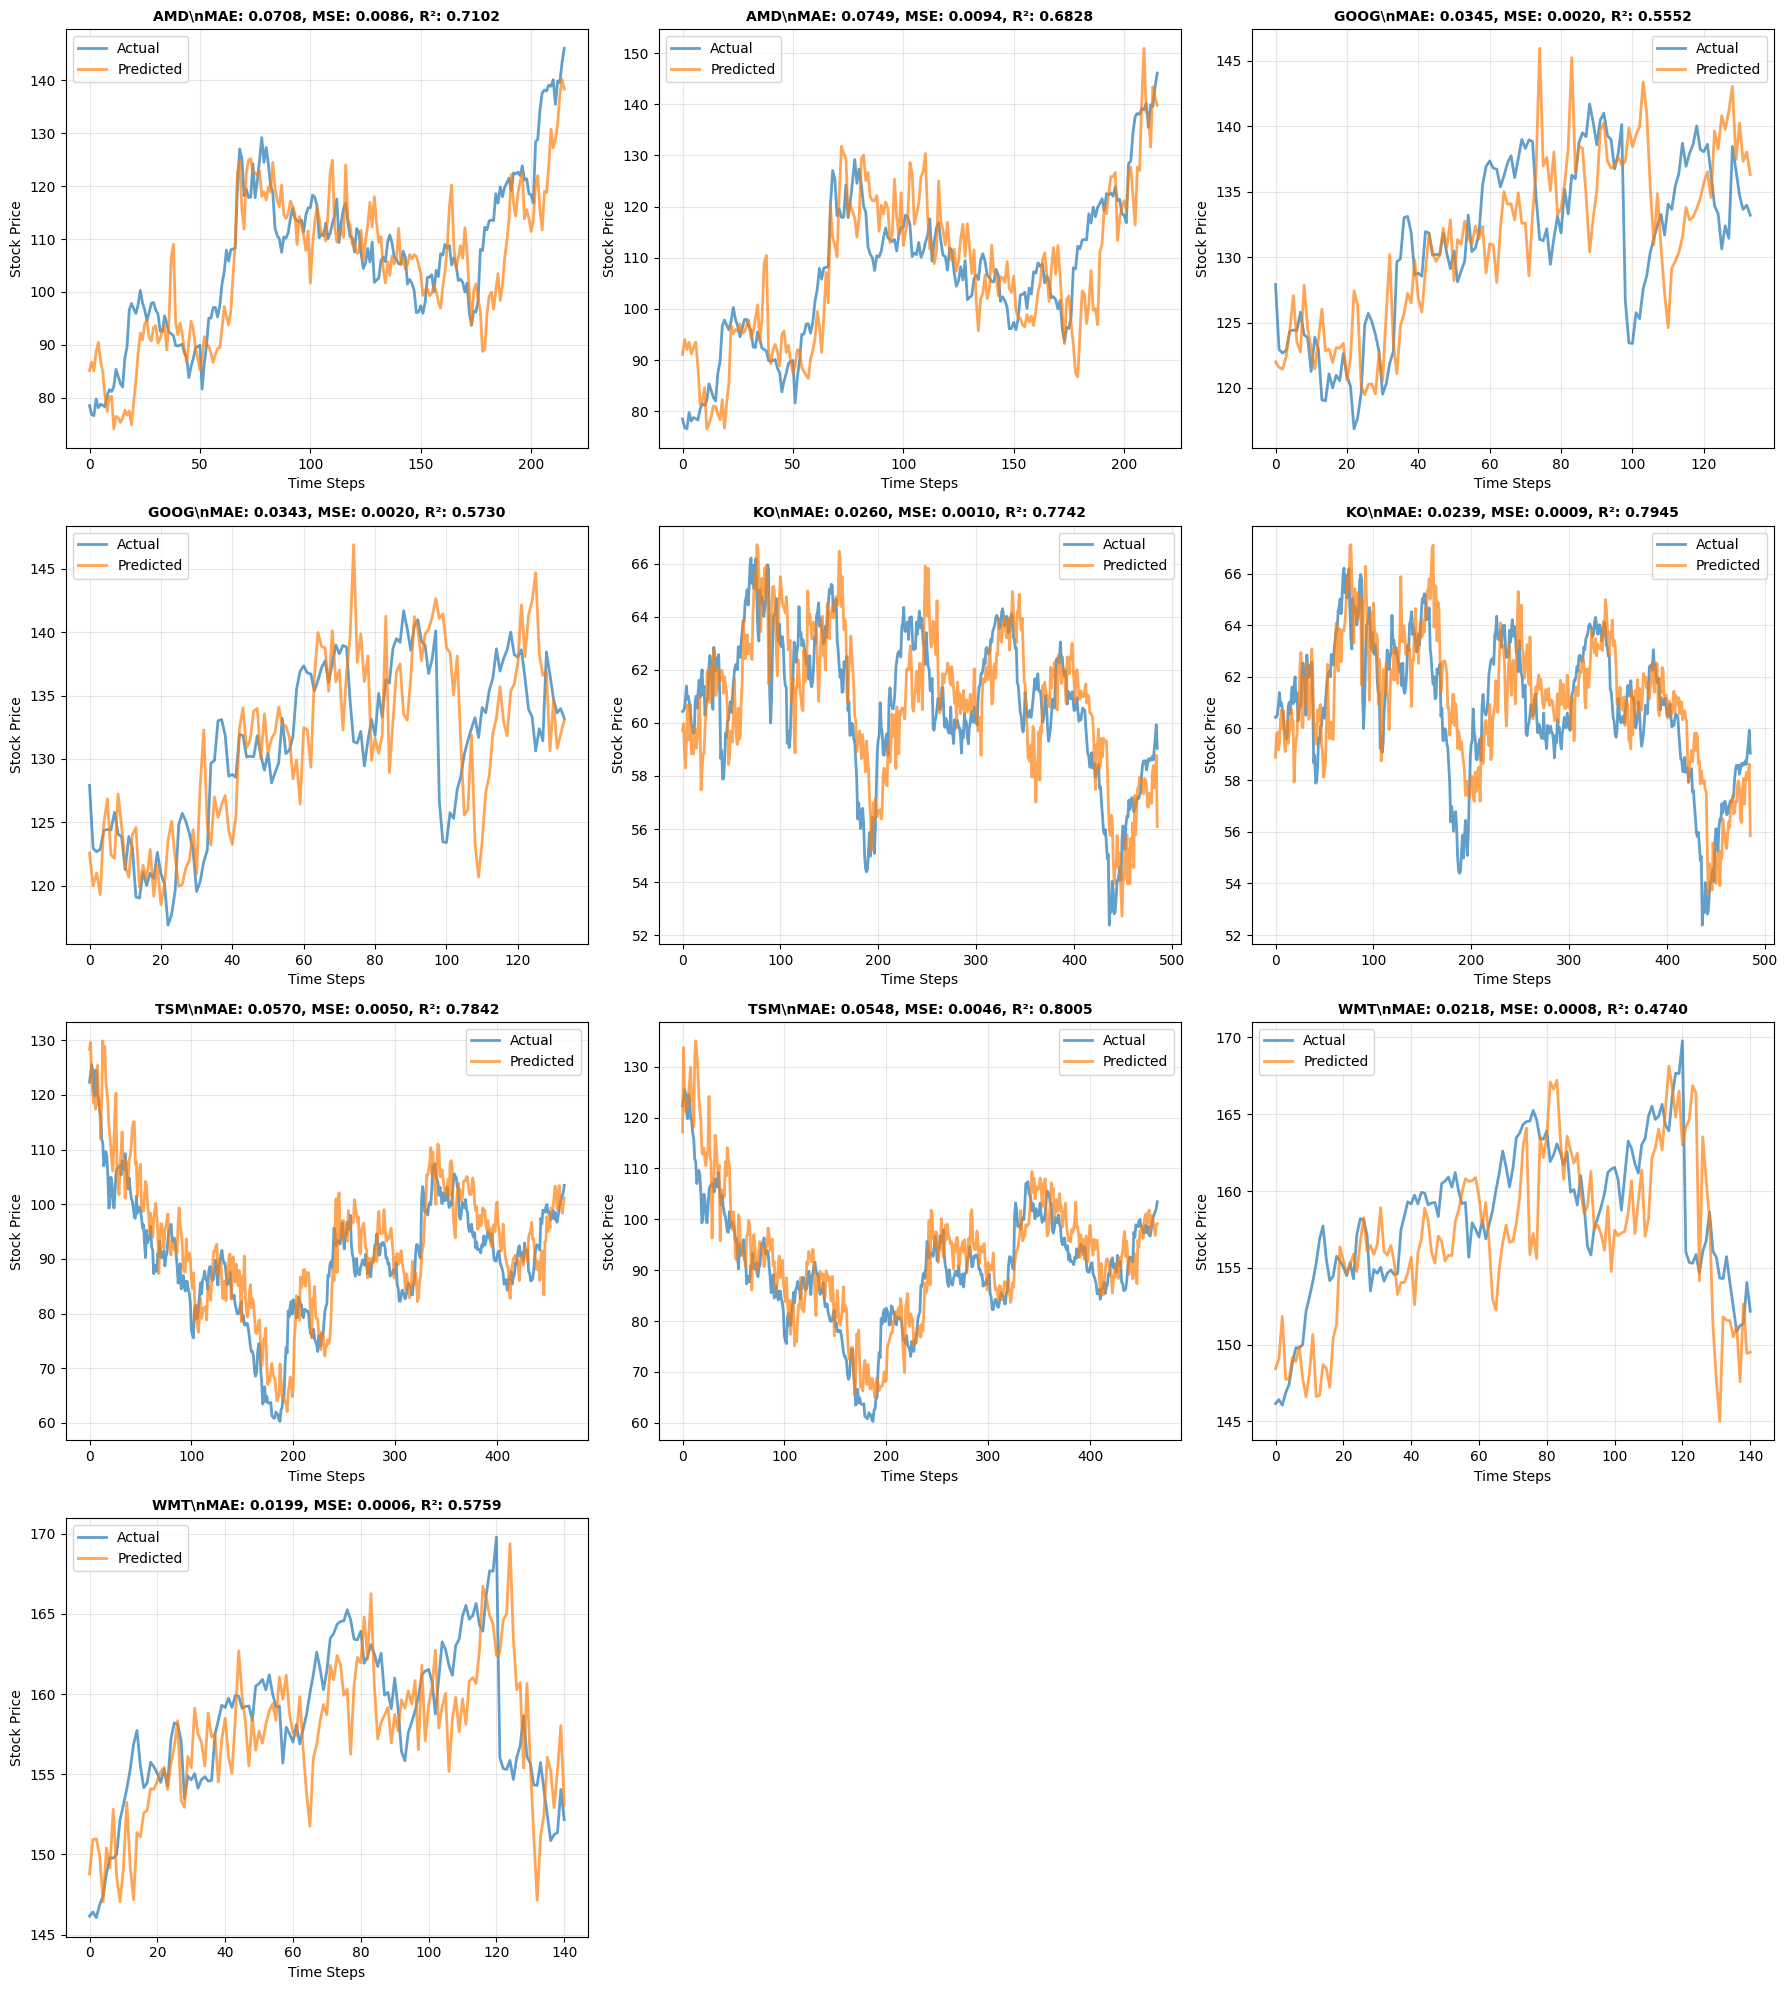

Folder test_result_25 not found, skipping...
Folder test_result_50 not found, skipping...


In [8]:
import glob
import matplotlib.pyplot as plt
import os

def plot_predictions_vs_actual(test_result_folder, num_stocks_list=[5, 25, 50]):
    """
    Create plots comparing predictions vs actual values for all test results.
    
    Parameters:
    test_result_folder: Base folder name (e.g., 'test_result_')
    num_stocks_list: List of test sizes to plot
    """
    
    for num_stocks in num_stocks_list:
        result_folder = f"{test_result_folder}{num_stocks}"
        
        if not os.path.exists(result_folder):
            print(f"Folder {result_folder} not found, skipping...")
            continue
            
        # Get all subfolders (each stock result)
        subfolders = glob.glob(os.path.join(result_folder, '*'))
        
        if not subfolders:
            print(f"No results found in {result_folder}")
            continue
        
        print(f"\n{'='*60}")
        print(f"Plotting results for {num_stocks} stocks")
        print(f"{'='*60}")
        
        # Create a figure for each test size
        n_stocks = len(subfolders)
        cols = 3
        rows = (n_stocks + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(18, 5*rows))
        if n_stocks == 1:
            axes = [axes]
        else:
            axes = axes.flatten()
        
        for idx, subfolder in enumerate(tqdm(sorted(subfolders), desc=f"Plotting {num_stocks} stocks", leave=False)):
            csv_file = os.path.join(subfolder, f"{os.path.basename(subfolder)}_predicted_data.csv")
            eval_file = os.path.join(subfolder, f"{os.path.basename(subfolder)}_eval.csv")
            
            if not os.path.exists(csv_file):
                print(f"CSV file not found: {csv_file}")
                continue
            
            # Read data
            df = pd.read_csv(csv_file)
            stock_name = os.path.basename(subfolder).split('_')[0]
            
            # Read evaluation metrics
            eval_metrics = {}
            if os.path.exists(eval_file):
                eval_df = pd.read_csv(eval_file)
                eval_metrics = {
                    'MAE': eval_df['MAE'].values[0],
                    'MSE': eval_df['MSE'].values[0],
                    'R2': eval_df['R2'].values[0]
                }
            
            # Plot
            ax = axes[idx]
            ax.plot(df['True_Data_origin'], label='Actual', linewidth=2, alpha=0.7)
            ax.plot(df['Predicted_Data_origin'], label='Predicted', linewidth=2, alpha=0.7)
            
            # Add metrics to title
            title = f"{stock_name}\\n"
            if eval_metrics:
                title += f"MAE: {eval_metrics['MAE']:.4f}, MSE: {eval_metrics['MSE']:.4f}, R²: {eval_metrics['R2']:.4f}"
            
            ax.set_title(title, fontsize=10, fontweight='bold')
            ax.set_xlabel('Time Steps')
            ax.set_ylabel('Stock Price')
            ax.legend(loc='best')
            ax.grid(True, alpha=0.3)
        
        # Hide unused subplots
        for idx in range(n_stocks, len(axes)):
            axes[idx].set_visible(False)
        
        plt.tight_layout()
        
        # Save figure
        plot_filename = f"predictions_vs_actual_{num_stocks}_stocks.png"
        plt.savefig(plot_filename, dpi=150, bbox_inches='tight')
        print(f"Plot saved as {plot_filename}")
        plt.show()

# Run the plotting function
plot_predictions_vs_actual('test_result_')

## 8. Visualization: Predictions vs Actual Values

The following cells generate plots comparing predicted prices with actual prices for each stock and test size.

Metrics plot saved as evaluation_metrics_5_stocks.png


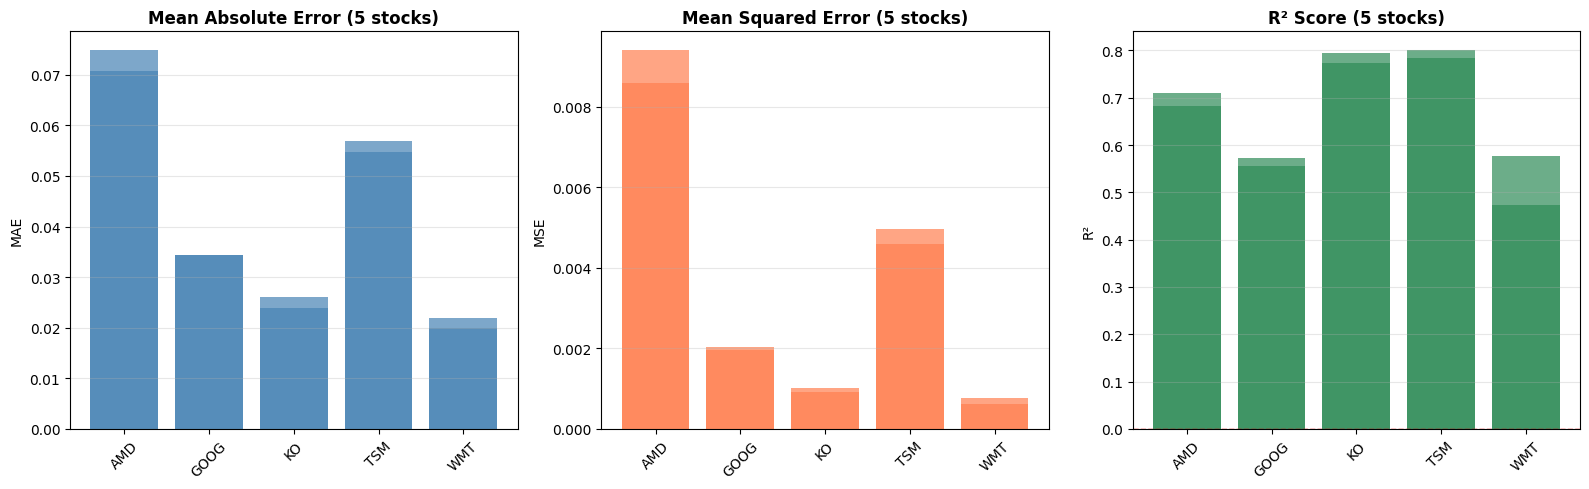


Summary Statistics for 5 stocks
MAE  - Mean: 0.0418, Std: 0.0197
MSE  - Mean: 0.0035, Std: 0.0031
R²   - Mean: 0.6724, Std: 0.1131


In [9]:
def plot_evaluation_metrics_summary(test_result_folder='test_result_', num_stocks_list=[5, 25, 50]):
    """
    Create a bar plot comparing evaluation metrics (MAE, MSE, R²) across all stocks.
    
    Parameters:
    test_result_folder: Base folder name (e.g., 'test_result_')
    num_stocks_list: List of test sizes to plot
    """
    
    for num_stocks in num_stocks_list:
        result_folder = f"{test_result_folder}{num_stocks}"
        
        if not os.path.exists(result_folder):
            continue
            
        subfolders = glob.glob(os.path.join(result_folder, '*'))
        
        if not subfolders:
            continue
        
        # Collect metrics
        stocks = []
        mae_values = []
        mse_values = []
        r2_values = []
        
        for subfolder in tqdm(sorted(subfolders), desc=f"Processing metrics for {num_stocks} stocks", leave=False):
            eval_file = os.path.join(subfolder, f"{os.path.basename(subfolder)}_eval.csv")
            
            if os.path.exists(eval_file):
                stock_name = os.path.basename(subfolder).split('_')[0]
                eval_df = pd.read_csv(eval_file)
                
                stocks.append(stock_name)
                mae_values.append(eval_df['MAE'].values[0])
                mse_values.append(eval_df['MSE'].values[0])
                r2_values.append(eval_df['R2'].values[0])
        
        if not stocks:
            continue
        
        # Create subplots for metrics
        fig, axes = plt.subplots(1, 3, figsize=(16, 5))
        
        # Plot MAE
        axes[0].bar(stocks, mae_values, color='steelblue', alpha=0.7)
        axes[0].set_title(f'Mean Absolute Error ({num_stocks} stocks)', fontweight='bold')
        axes[0].set_ylabel('MAE')
        axes[0].tick_params(axis='x', rotation=45)
        axes[0].grid(True, alpha=0.3, axis='y')
        
        # Plot MSE
        axes[1].bar(stocks, mse_values, color='coral', alpha=0.7)
        axes[1].set_title(f'Mean Squared Error ({num_stocks} stocks)', fontweight='bold')
        axes[1].set_ylabel('MSE')
        axes[1].tick_params(axis='x', rotation=45)
        axes[1].grid(True, alpha=0.3, axis='y')
        
        # Plot R²
        axes[2].bar(stocks, r2_values, color='seagreen', alpha=0.7)
        axes[2].set_title(f'R² Score ({num_stocks} stocks)', fontweight='bold')
        axes[2].set_ylabel('R²')
        axes[2].tick_params(axis='x', rotation=45)
        axes[2].axhline(y=0, color='red', linestyle='--', linewidth=1)
        axes[2].grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        
        # Save figure
        plot_filename = f"evaluation_metrics_{num_stocks}_stocks.png"
        plt.savefig(plot_filename, dpi=150, bbox_inches='tight')
        print(f"Metrics plot saved as {plot_filename}")
        plt.show()
        
        # Print summary statistics
        print(f"\n{'='*60}")
        print(f"Summary Statistics for {num_stocks} stocks")
        print(f"{'='*60}")
        print(f"MAE  - Mean: {np.mean(mae_values):.4f}, Std: {np.std(mae_values):.4f}")
        print(f"MSE  - Mean: {np.mean(mse_values):.4f}, Std: {np.std(mse_values):.4f}")
        print(f"R²   - Mean: {np.mean(r2_values):.4f}, Std: {np.std(r2_values):.4f}")

# Run the metrics plotting function
plot_evaluation_metrics_summary('test_result_')

## 9. Evaluation Metrics Summary

Compare evaluation metrics (MAE, MSE, R²) across all stocks for each test size.